# Datasets
Some source of the Github datasets are brought into consideration:
https://github.com/epicprojects/blockchain-anomaly-detection

Perform

Derived Dataset URL: https://www.kaggle.com/datasets/omershafiq/bitcoin-network-transactional-metadata

Original Dataset URL: https://ieee-dataport.org/open-access/bitcoin-transactions-data-2011-2013

Dataset URL (for working): https://drive.google.com/file/d/11luI0c2ODA8AGiY3GxakBQBcU91eVShL/view?usp=sharing

## [DG_out.csv](https://www.kaggle.com/datasets/omershafiq/bitcoin-network-transactional-metadata?select=DG_out.csv)

### Dimensions:
tx_hash: Hash of the bitcoin transaction.

indegree: Number of transactions that are inputs of tx_hash

outdegree: Number of transactions that are outputs of tx_hash.

in_btc: Number of bitcoins on each incoming edge to tx_hash.

out_btc: Number of bitcoins on each outgoing edge from tx_hash.

total_btc: Net number of bitcoins flowing in and out from tx_hash.

mean_in_btc: Average number of bitcoins flowing in for tx_hash.

mean_out_btc: Average number of bitcoins flowing out for tx_hash. 

in-malicious: Will be 1 if the tx_hash is an input of a malicious transaction.

out-malicious: Will be 1 if the tx_hash is an output of a malicious transaction.

is-malicious: Will be 1 if the tx_hash is a malicious transaction. (based on https://www.kaggle.com/omershafiq/bitcoin-hacks-2010to2013)

out_and_tx_malicious: Will be 1 if the tx_hash is a malicious transaction or an output of a malicious transaction.

all_malicious: Will be 1 if the tx_hash is a malicious transaction or an output of a malicious transaction or input of a malicious transaction.



## Note(s):

* A directed-acyclic graph (DAG) was created from the bitcoin network transaction data (https://ieee-dataport.org/open-access/bitcoin-transactions-data-2011-2013) and metadata was extracted to create this dataset.

# Settings
Some settings are placed here to allow some customizations when running the whole notebook. In primary, this is implemented to prevent running some code that requires a lot of time running. For debugging purposes.


In [135]:
use_dask_df = False
number_dataset_records = 1000000 # Only for Panda (Max 30248134)
read_dataset_rows = False
check_normal_distributions = True
show_visualizations = True
show_histograms = True
show_scatterplots = True
show_qqplots = True
remove_outliers_with_z_score = True
remove_outliers_with_IQR = True
check_multicollinearity = True
# Excluded Column(s): Column(s) that is not relevant for the whole process.
excluded_columns = ['tx_hash']
target_variable = 'is_malicious'

# DNN
run_dnn_model_1 = False
run_dnn_model_2 = True

# RNN
run_rnn_model_1 = False
run_rnn_model_2 = False


# Import libraries

## Standard libraries for data manipulation and visualization

In [136]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from scipy.stats import shapiro
from sklearn.metrics import auc, average_precision_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve
import seaborn as sns

## Libraries for machine learning and deep learning


In [137]:
import dask.dataframe as dd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras import initializers, regularizers
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

## Library for accessing Google Drive

In [138]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


# Load the dataset

In [139]:
filename = '/drive/My Drive/apu-dl-datasets/DG_out.csv'

In [140]:
# Count dataset number of lines to inform the dataset size first
def count_dataset_rows(file_name):
    fp = open(file_name,'r')
    for line_count, line in enumerate(fp):
        pass
    return line_count
if read_dataset_rows:
  file_line_count = count_dataset_rows(filename)
  print('file_line_count for DG_out.csv: ', file_line_count)

There are 30,248 134 (approximately 30.2 million) Bitcoin transactions in DG_out.csv, which is very large dataset for Google Collab for processing. It will take huge amount of time to visualize, perform data engineering and modelling process. So only a portion of dataset is taken for analysis.

There are 66,199,072 (approximately 66.2 million) Bitcoin transactions in btc_tx_2011_2013.csv. This means that the 

In [141]:
# Read specific number of records from the dataset
def load_dataset():
  if use_dask_df:
    df = dd.read_csv(filename)
  else:
    df = pd.read_csv(filename,nrows=number_dataset_records)
  print(f'Number of records in DG_out.csv: {len(df)}')
  return df

df = load_dataset()

Number of records in DG_out.csv: 1000000


In [142]:
df.sample(3)

,tx_hash,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,in_malicious,out_malicious,is_malicious,out_and_tx_malicious,all_malicious
807632,59abfa0036c076fd3c2756a7453eedeaef4bba92b48c15...,1,2,0.2215,0.221,0.4425,0.2215,0.1105,0,0,0,0,0
55230,e4b11e6bf664d2d20968a7636ae5481bfaad6c04e3ec22...,1,1,0.0500,0.050,0.1000,0.0500,0.0500,0,0,0,0,0
393959,f39b7e16d8f14c248fa0450f543420665befc71d9c61d6...,4,1,1.0000,1.000,2.0000,0.2500,1.0000,0,0,0,0,0


Note: If nrows argument is not specified in Pandas.read_csv(), loading the file will make Google Collab session to crash due to running out of GPU memory. So, some solution can be made, which use Dask library to load dataset in parallel. But, the processing takes a long time for the session, hence only a subset is taken for deep learning model.

# Exploratory Data Analysis (EDA)

In [143]:
df.shape

(1000000, 13)

# Column Categorization

Based on the description, the dataset columns can be listed out as the following:

Then, the type of the columns are defined to make preliminary analysis of the dataset easier.

In [144]:
# Print the column names
df.columns

Index(['tx_hash', 'indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc',
       'mean_in_btc', 'mean_out_btc', 'in_malicious', 'out_malicious',
       'is_malicious', 'out_and_tx_malicious', 'all_malicious'],
      dtype='object')

Quick overview of the dataframe from the dataset:

In [145]:
print(f"df.head(): {df.head()}")

print(f"df.info(): {df.info()}")

print(f"df.describe(): {df.describe()}")

df.head():                                              tx_hash  indegree  outdegree  \
0  0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...         0          1   
1  f4184fc596403b9d638783cf57adfe4c75c605f6356fbc...         1          2   
2  ea44e97271691990157559d0bdd9959e02790c34db6c00...         1          1   
3  a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...         1          1   
4  591e91f809d716912ca1d4a9295e70c3e78bab077683f7...         1          2   

   in_btc  out_btc  total_btc  mean_in_btc  mean_out_btc  in_malicious  \
0     0.0     50.0       50.0          0.0          50.0             0   
1    50.0     50.0      100.0         50.0          25.0             0   
2    10.0     10.0       20.0         10.0          10.0             0   
3    40.0     30.0       70.0         40.0          30.0             0   
4    30.0     30.0       60.0         30.0          15.0             0   

   out_malicious  is_malicious  out_and_tx_malicious  all_malicious  
0          

The datetime column is not in the correct format as it contains date and time of the transaction. The following has been made to transform the object type of the datetime column:

### Analysing Columns

Check the distinct values of each column:

In [146]:
# Get count of unique values for all columns in the dataframe
df.nunique()

tx_hash                 1000000
indegree                    252
outdegree                   252
in_btc                   302328
out_btc                  289593
total_btc                335396
mean_in_btc              320560
mean_out_btc             316601
in_malicious                  2
out_malicious                 2
is_malicious                  2
out_and_tx_malicious          2
all_malicious                 2
dtype: int64

Analysis:

* tx_hash column is unique identifier of the dataset transactions. 

In [147]:
# Remove any specified columns
def drop_execption_columns(df):
  for index, column_name in enumerate(excluded_columns):
    df = df.drop(excluded_columns, axis=1)
    return df

df = drop_execption_columns(df)

From the above, tx_hash column is a unique identifier for each record and doesn't provide any useful information for your analysis. Removing it to simplify the data and reduce the number of features in the model.

In [148]:
# Check dataset
df.sample(3)

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,in_malicious,out_malicious,is_malicious,out_and_tx_malicious,all_malicious
364075,1,1,193.910000,193.810000,387.720000,193.910000,193.810000,0,0,0,0,0
583479,1,2,123.793137,123.793137,247.586274,123.793137,61.896569,0,0,0,0,0
368615,1,2,0.240000,0.240000,0.480000,0.240000,0.120000,0,0,0,0,0


Categorizing the columns into lists.

In [149]:
# Binary Column(s): Column(s) that either have 0 or 1 as value.
binary_columns = []
# binary_columns = ['in_malicious', 'out_malicious', 'is_malicious', 'out_and_tx_malicious', 'all_malicious']

# Multi-class Column(s) = Column(s) that have varying or continuous values.
multiclass_columns = []
# multiclass_columns = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']

def categorize_columns():
  for column_name in df.columns:
      if column_name not in excluded_columns:
        unique_vals = df[column_name].unique()
        num_unique_vals = len(unique_vals)
        if num_unique_vals == 2:
            binary_columns.append(column_name)
        elif num_unique_vals > 2:
            multiclass_columns.append(column_name)
      else:
        continue

categorize_columns()

print(f'Length of binary_columns variable is {len(binary_columns)}. List: {binary_columns}')
print(f'Length of multiclass_columns variable is {len(multiclass_columns)}. List: {multiclass_columns}')

Length of binary_columns variable is 5. List: ['in_malicious', 'out_malicious', 'is_malicious', 'out_and_tx_malicious', 'all_malicious']
Length of multiclass_columns variable is 7. List: ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']


Visual inspection of the columns as Histograms, Scatterplot or Probability Plot (known as Q-Q plot), based on the data nature of each column.

In [150]:
def show_column_histogram(column_name):
  plt.hist(df[column_name],bins=50)
  plt.xlabel(column_name)
  plt.ylabel('Frequency')
  plt.title(f'Histogram of {column_name}')
  plt.show()
  return;

def show_column_scatterplot(column_a_name, column_b_name):
  plt.scatter(df[column_a_name], df[column_b_name])
  plt.xlabel(column_a_name)
  plt.ylabel(column_b_name)
  plt.title(f'Scatterplot of {column_a_name} vs {column_b_name}')
  plt.show()

def show_column_qqplot(column_name):
  stats.probplot(df[column_name], dist="norm", plot=plt)

#### Normal Distribution

Check normal distribution for multiclass/continuous variables/columns/attributes, using **Shapiro-Wilk** test. It provides a p-value that indicates the graph is normally distributed.

A p-value greater than 0.05 indicates that the data is likely to be normally distributed.

Lesser than 0.05 indicates that the data is NOT likely to be normally distributed.

In [151]:
# List that corresponds to the mutliclass/continuous variables.
# True = Likely to be normally distributed.
# False = Not likely to be normally distributed.

if check_normal_distributions:
  column_normally_distributed = []

  def get_normal_distribution_p_value(column_name):
    stat, p = shapiro(df[column_name])
    print('p: ', p)
    print('stat: ', stat)
    if p > 0.05:
      print(f'{column_name} is normally distributed. with p-value: {p}')
      return True;
    else:
      print(f'{column_name} is NOT normally distributed., with p-value: {p}')
      return False;

    return p > 0.05;

  for index, column_name in enumerate(multiclass_columns):
    column_normally_distributed.append(get_normal_distribution_p_value(column_name))

  print('column_normally_distributed: ', column_normally_distributed)


p:  0.0
stat:  0.10363715887069702
indegree is NOT normally distributed., with p-value: 0.0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p:  0.0
stat:  0.05312603712081909
outdegree is NOT normally distributed., with p-value: 0.0
p:  0.0
stat:  0.027079403400421143
in_btc is NOT normally distributed., with p-value: 0.0
p:  0.0
stat:  0.026910006999969482
out_btc is NOT normally distributed., with p-value: 0.0
p:  0.0
stat:  0.027162671089172363
total_btc is NOT normally distributed., with p-value: 0.0
p:  0.0
stat:  0.027348697185516357
mean_in_btc is NOT normally distributed., with p-value: 0.0
p:  0.0
stat:  0.025756895542144775
mean_out_btc is NOT normally distributed., with p-value: 0.0
column_normally_distributed:  [False, False, False, False, False, False, False]


From the previous output, the multiclass_columns' values are not normally distributed. Use histogram and scatterplot to check visually:

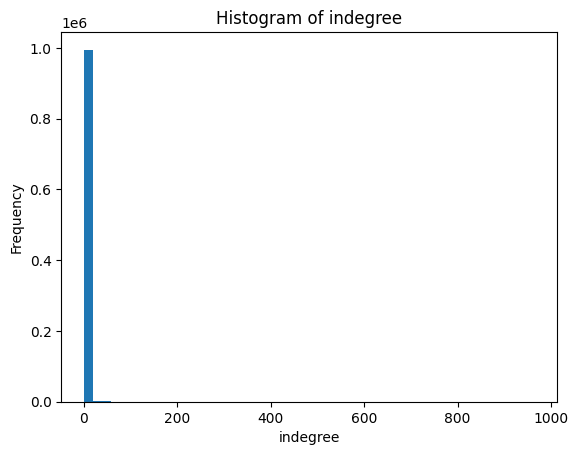

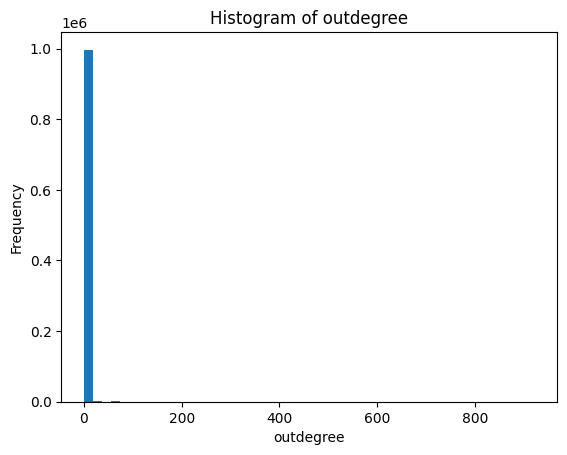

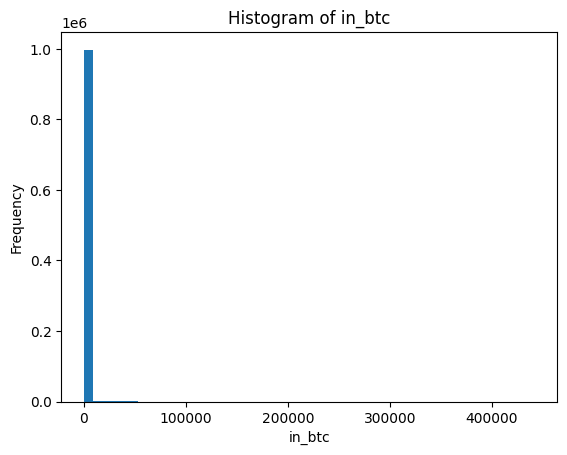

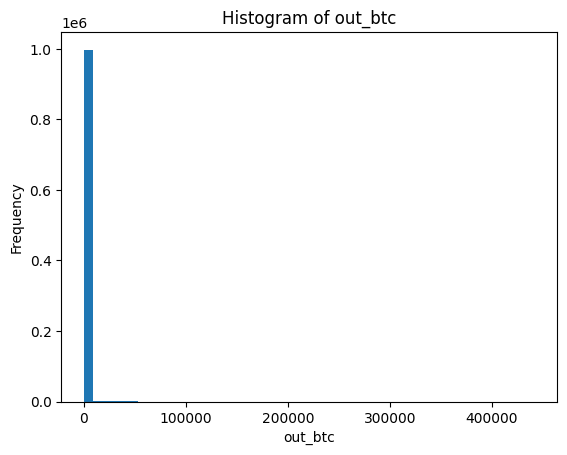

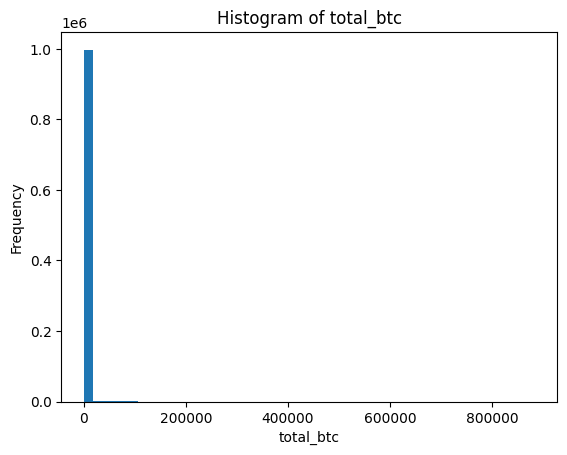

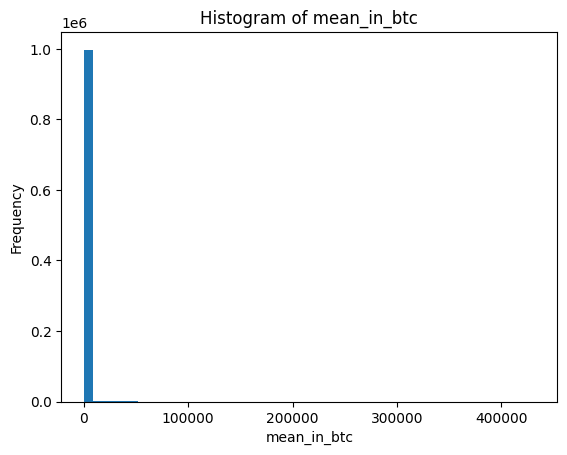

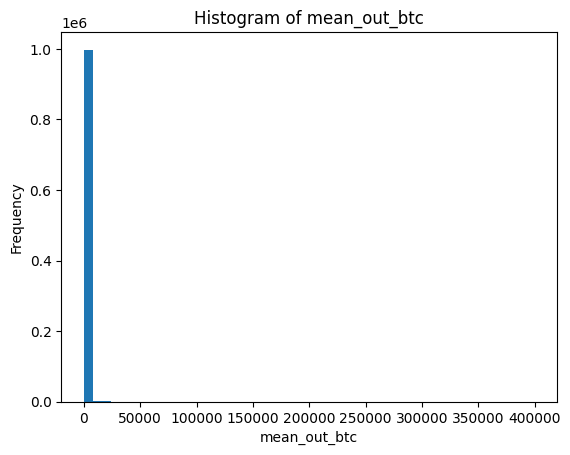

In [152]:
# Multiclass/Continuous variables/attributes/columns Histograms
if show_visualizations and show_histograms:
  for multiclass_column_name in multiclass_columns:
    show_column_histogram(multiclass_column_name)

Based on the histograms of multiclass_columns list, there are more than one value other than 0, but hard to visualize the values more than 0.

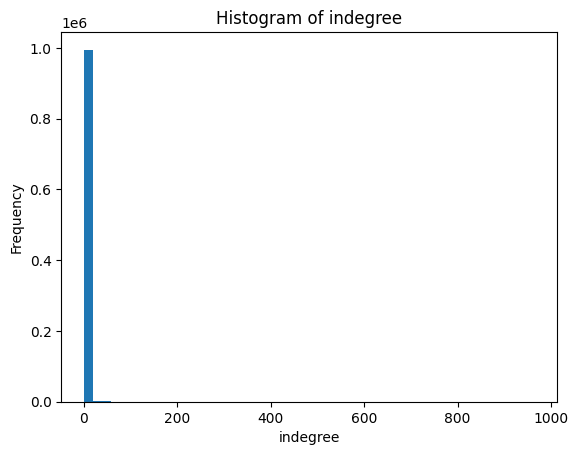

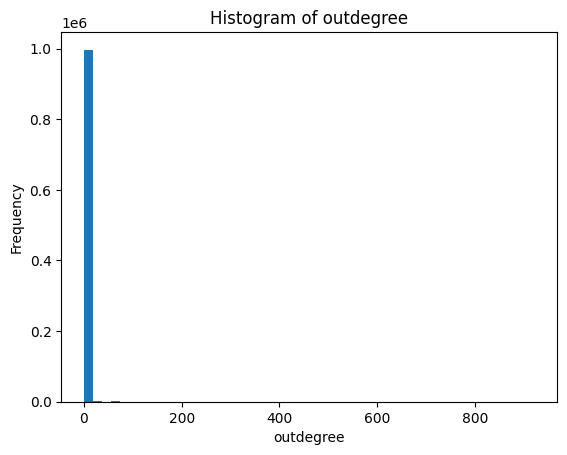

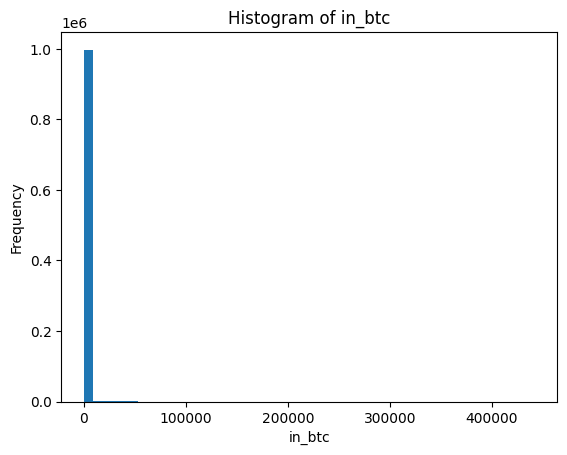

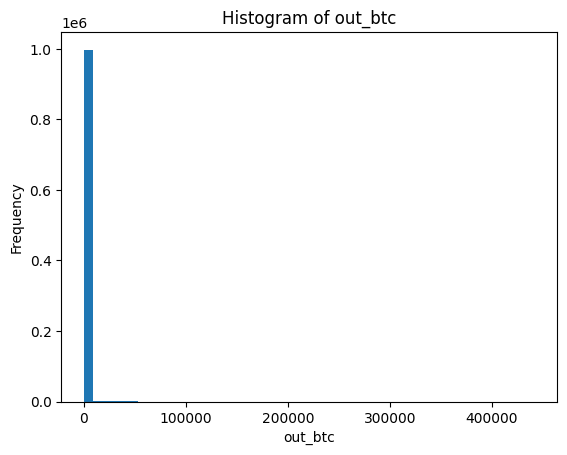

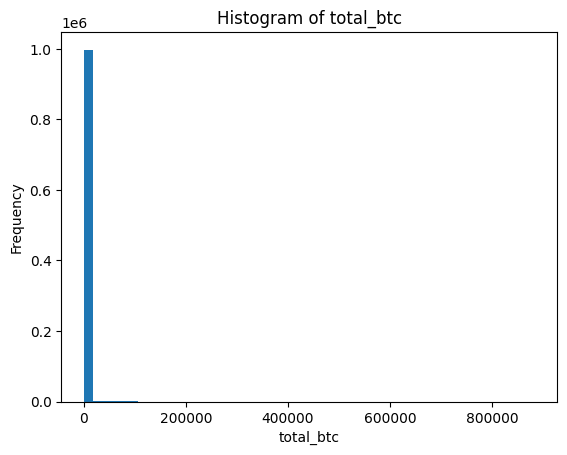

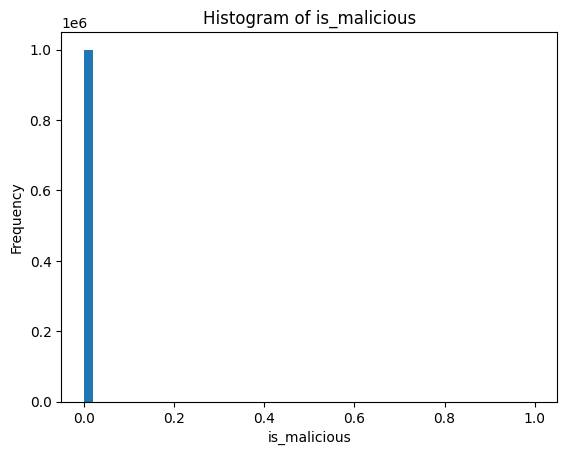

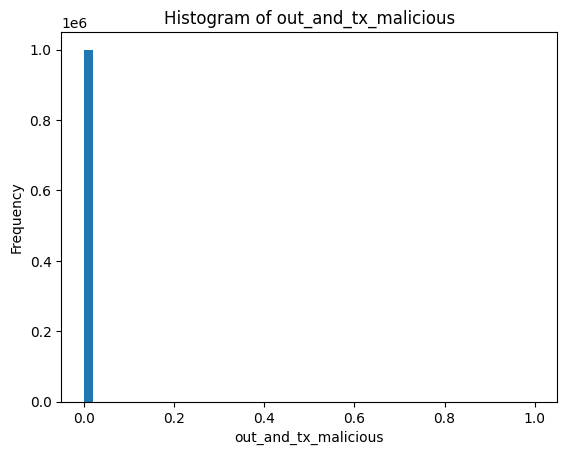

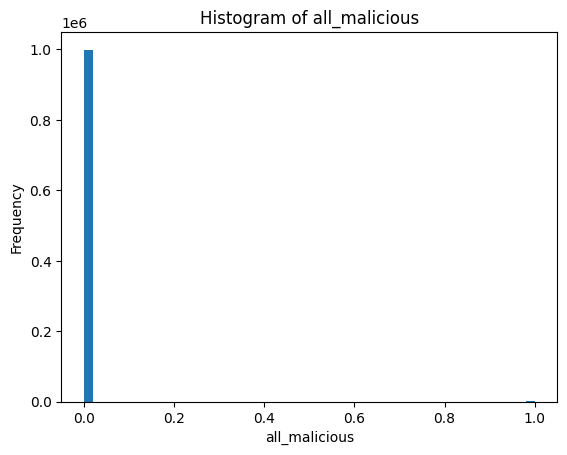

In [153]:
if show_visualizations and show_histograms:
  show_column_histogram('indegree')
  show_column_histogram('outdegree')
  show_column_histogram('in_btc')
  show_column_histogram('out_btc')
  show_column_histogram('total_btc')
  show_column_histogram('is_malicious')
  show_column_histogram('out_and_tx_malicious')
  show_column_histogram('all_malicious')

For the histograms, in_btc, out_btc and total_btc columns have most of the value in zero, with very fine second line which indicates second or more distinct value. Hence, scatterplots are made to further visualize the dataset columns in possible combinations.

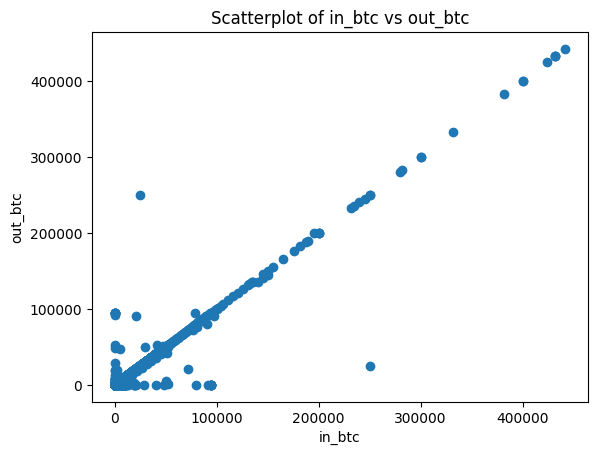

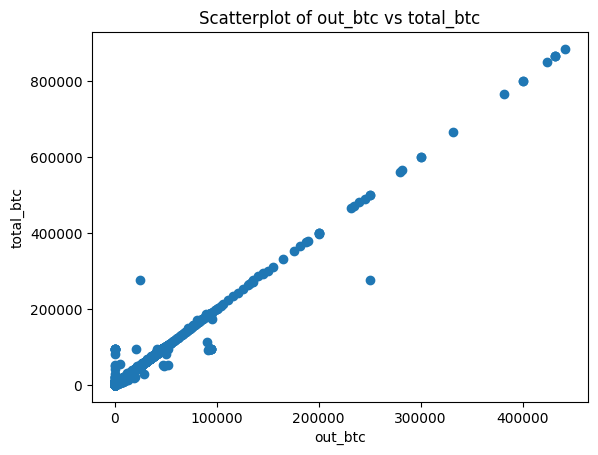

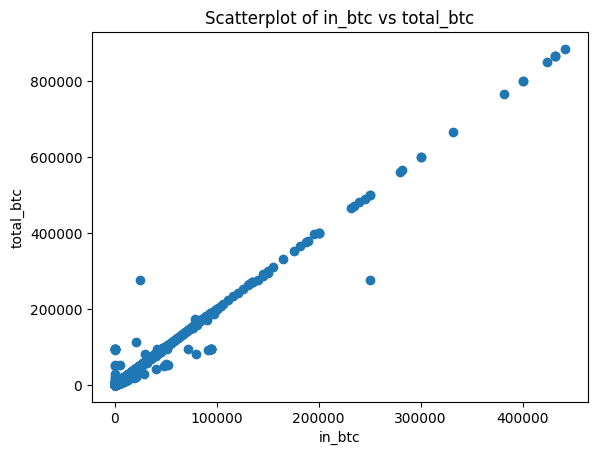

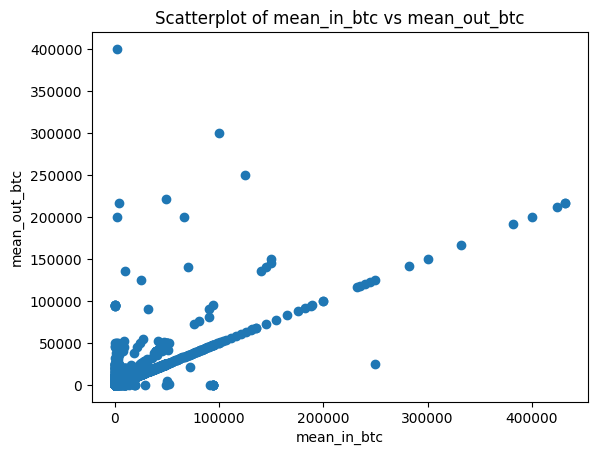

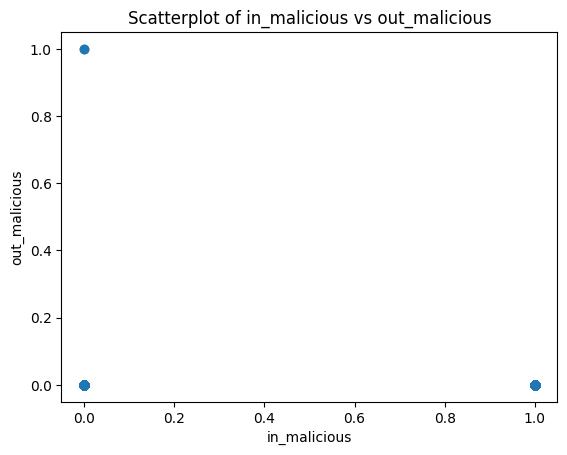

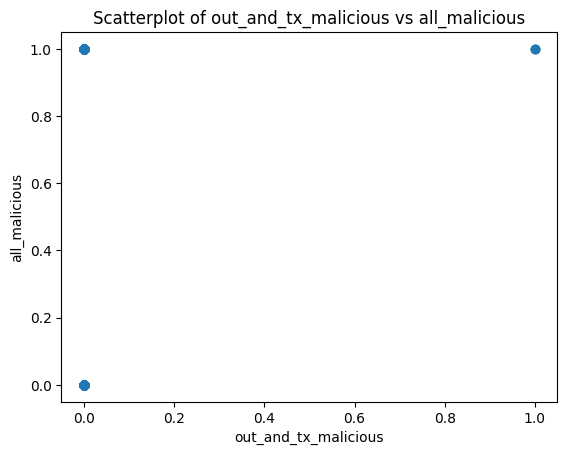

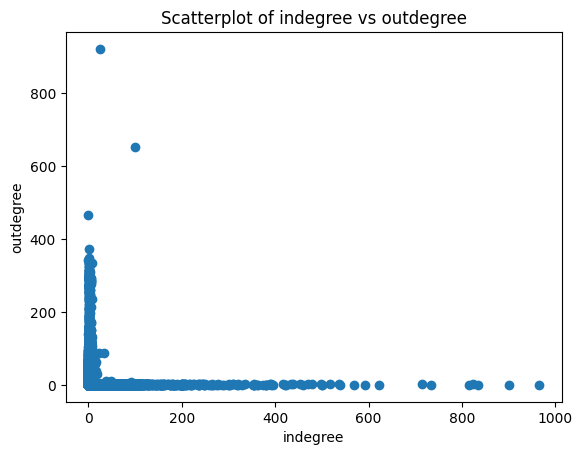

In [154]:
if show_visualizations and show_scatterplots:
  show_column_scatterplot('in_btc','out_btc')
  show_column_scatterplot('out_btc','total_btc')
  show_column_scatterplot('in_btc','total_btc')
  show_column_scatterplot('mean_in_btc','mean_out_btc')
  show_column_scatterplot('in_malicious','out_malicious')
  show_column_scatterplot('out_and_tx_malicious','all_malicious')
  show_column_scatterplot('indegree','outdegree')

From the above scatterplots, the data of in_btc, out_btc, total_btc are following normal distributions, with only some outliers needs to be cleaned visually.

Based on the observation of the scatterplot of mean_in_btc vs mean_out_btc above, most of the data is following normal distribution, with minimal data outlier spotted.

For the indegree vs outdegree scatterplot, they do not follow the normal distribution and linear relationship with each other.

# Detecting Outliers

## Z-Score

### FAQs

* Why 3 is the standard value of *z-score*?

The value 3 is often used as a standard threshold for identifying outliers based on their *Z-scores* because it corresponds to approximately **99.7%** of the data being within the range of 3 standard deviations from the mean in a normal distribution.

In other words, if the distribution of the data is approximately normal, then any values with a *Z-score* greater than 3 or less than -3 are very unlikely to occur by chance, and are therefore considered to be outliers. However, it is worth noting that the choice of the threshold value for identifying outliers can depend on the specific context and the distribution of the data, and there may be cases where a different threshold value is more appropriate.

In [155]:
# Z-Score Methods

z_score_threshold = 3

def calculate_z_score(column_name):
  z_scores = (df[column_name] - df[column_name].mean()) / df[column_name].std()
  print(f'The z-score of the {column_name} is: {z_scores}')
  return z_scores;

def get_outliers_by_z_score(column_name, z_scores):
  outliers = df[abs(z_scores) > z_score_threshold]
  num_outliers = outliers.shape[0]  # get the number of rows in the outliers DataFrame
  print(f'Number of outliers in {column_name}: {num_outliers}')
  print(outliers.head())

def remove_outliers_by_z_score(column_name, z_scores):
  df_filtered = df[abs(z_scores) <= z_score_threshold]
  return df_filtered

## Inter-Quartile Range (IQR)



In [156]:
# Inter-Quartile Range Methods

def remove_outliers_by_iqr(column_name):
  Q1 = df[column_name].quantile(0.25)
  Q3 = df[column_name].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  
  df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
  
  num_outliers = df.shape[0] - df_filtered.shape[0]
  print(f'Number of outliers in {column_name}: {num_outliers}')

  return df_filtered

In [157]:
def remove_outliers_all_columns(df):
  # Check for missing values
  print(f'Missing values: \n{df.isnull().sum()}')

  # Check for duplicated records
  print(f'Duplicated records: \n{df.duplicated().sum()}')

  # Drop the records that have incomplete information
  df = df.dropna()

  # Drop the records that are duplicate as they don't add any additional information and may cause bias in the model
  df.drop_duplicates(inplace=True)

  for index, column_name in enumerate(multiclass_columns):
      # Z-Score
      if remove_outliers_with_z_score:
        z_scores = calculate_z_score(column_name)
        get_outliers_by_z_score(column_name,z_scores)
        df = remove_outliers_by_z_score(column_name, z_scores)

      # IQR
      if remove_outliers_with_IQR:
        df = remove_outliers_by_iqr(column_name)
  return df

df = remove_outliers_all_columns(df)

Missing values: 
indegree                0
outdegree               0
in_btc                  0
out_btc                 0
total_btc               0
mean_in_btc             0
mean_out_btc            0
in_malicious            0
out_malicious           0
is_malicious            0
out_and_tx_malicious    0
all_malicious           0
dtype: int64
Duplicated records: 
548240
The z-score of the indegree is: 0        -0.300855
1        -0.110560
2        -0.110560
3        -0.110560
4        -0.110560
            ...   
999995   -0.300855
999996   -0.110560
999997    0.460326
999998   -0.110560
999999   -0.110560
Name: indegree, Length: 1000000, dtype: float64
Number of outliers in indegree: 5916
     indegree  outdegree    in_btc  out_btc  total_btc  mean_in_btc  \
29         20          1   1000.00   1000.0    2000.00    50.000000   
98         30          1   1500.00   1500.0    3000.00    50.000000   
108        20          1   1000.00   1000.0    2000.00    50.000000   
190       901       

**CHECK** the datasets after outlier removal

In [158]:
df.shape

(930797, 12)

## Check Multicollinearity
Before that, check the correlation of the binary columns to prevent overfitting issue in the model later.

In [159]:
def build_correlation_matrix(df):
  print('Correlation Matrix of Binary Columns:')
  binary_df = df[binary_columns]

  # compute the correlation matrix
  corr_matrix = binary_df.corr(method='pearson')

  # print the correlation matrix
  print(corr_matrix)

  print('\n\n\n')
  print('Correlation Matrix of Continuous Columns:')
  multiclass_df = df[multiclass_columns]

  corr_matrix = multiclass_df.corr(method='pearson')

  print(corr_matrix)

if check_multicollinearity:
  build_correlation_matrix(df)

Correlation Matrix of Binary Columns:
                      in_malicious  out_malicious  is_malicious  \
in_malicious                   1.0            NaN           NaN   
out_malicious                  NaN            NaN           NaN   
is_malicious                   NaN            NaN           NaN   
out_and_tx_malicious           NaN            NaN           NaN   
all_malicious                  1.0            NaN           NaN   

                      out_and_tx_malicious  all_malicious  
in_malicious                           NaN            1.0  
out_malicious                          NaN            NaN  
is_malicious                           NaN            NaN  
out_and_tx_malicious                   NaN            NaN  
all_malicious                          NaN            1.0  




Correlation Matrix of Continuous Columns:
              indegree  outdegree    in_btc   out_btc  total_btc  mean_in_btc  \
indegree      1.000000   0.011956  0.018609 -0.035762   0.011812    -0.0

Based on the correlation matrix output above, it seems that there is a high correlation between in_malicious and all_malicious, which is not surprising since all_malicious includes in_malicious. This could potentially lead to ***multicollinearity*** issues in the modelling process, which can affect the performance and interpretability of the model.

in_btc, total_btc, and mean_in_btc are highly correlated with each other. 

*in_malicious* or *all_malicious* are highly correlated with each other.

Therefore, consider dropping either one of them to reduce the multicollinearity issue. You could also drop out_and_tx_malicious since it has a high correlation with out_malicious and may not provide additional information to the model. However, the final decision on which columns to drop should depend on the specific requirements of your analysis and the goals of your model.






In [160]:
def remove_multicollinearity_columns(df):
  # 1. in_btc, total_btc, and mean_in_btc are highly correlated.
  df = df.drop(['in_btc', 'total_btc'], axis=1)
  # 2. out_btc and mean_out_btc are highly correlated.
  df = df.drop(['out_btc'], axis=1)
  # 3. in_malicious or all_malicious are highly correlated.
  df = df.drop(['in_malicious'], axis=1)
  return df

if check_multicollinearity:
  df = remove_multicollinearity_columns(df)

In [161]:
# Check again
df.sample(3)

,indegree,outdegree,mean_in_btc,mean_out_btc,out_malicious,is_malicious,out_and_tx_malicious,all_malicious
450307,1,2,33.350000,16.675000,0,0,0,0
729740,2,2,0.079625,0.079625,0,0,0,0
690050,1,2,150.104936,75.052468,0,0,0,0


In [162]:
df.shape

(930797, 8)

# Building DNN

## Prepare Visualizations

### Loss and Accuracy Plot

### Confusion Matrix

A confusion matrix is a table used to evaluate the performance of a classification model. It shows the number of true positives, false positives, true negatives, and false negatives. You can use the scikit-learn library to calculate and plot the confusion matrix.

### ROC Curve

A ROC (Receiver Operating Characteristic) curve is a plot that shows the performance of a binary classifier as the discrimination threshold is varied. You can use the scikit-learn library to calculate the ROC curve and plot it using matplotlib.


### Precision-Recall Curve

A precision-recall curve is a plot of the precision (positive predictive value) versus the recall (sensitivity) for different threshold values. You can use the scikit-learn library to calculate the precision-recall curve and plot it using matplotlib.

In [163]:
def show_model_performance(X_test, y_test, model):
  # Evaluate the model
  lost, accuracy = model.evaluate(X_test, y_test, verbose=0)
  print('Loss:', lost)
  print('Accuracy:', accuracy)

def show_loss_and_accuracy_line_plot(history):
  # Plot the loss and accuracy over epochs
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

def show_confusion_matrix(y_test, model):
  # Generate the confusion matrix and classification report
  confusion_mtx = confusion_matrix(y_test, y_pred)
  print(confusion_mtx)
  print(classification_report(y_test, y_pred))

  # Visualize the confusion matrix
  sns.heatmap(confusion_mtx, annot=True, fmt='d')

def show_roc_curve_plot(y_test, y_pred):
  # Compute ROC curve and ROC area for each class
  fpr, tpr, _ = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)

  # Plot ROC curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

def show_precision_recall_curve_plot(y_test, y_pred):
  # Compute Precision-Recall curve and average precision for each class
  precision, recall, _ = precision_recall_curve(y_test, y_pred)
  average_precision = average_precision_score(y_test, y_pred)

  # Plot Precision-Recall curve
  plt.figure(figsize=(8, 6))
  plt.step(recall, precision, color='b', alpha=0.2, where='post')
  plt.fill_between(recall, precision, alpha=0.2, color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
  plt.show()

## Model Preparations

In [164]:
# Reload the dataset
# df = load_dataset()

# Drop exception columns
# df = drop_execption_columns(df)

# Categorize columns
# categorize_columns()

# Remove outliers
# df = remove_outliers_all_columns(df)

# df = remove_multicollinearity_columns(df)

# Randomize sample
df = df.sample(frac=1)

# Setting Target Variable
y = df[target_variable]
X = df.drop([target_variable],axis=1)

# Split Dataset: Split the datasets in 20:80 ratio. With fixed random seed to allow reproducible results.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# Print the datasets' dimension shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Data Normalization
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(744637, 7) (186160, 7) (744637,) (186160,)


## DNN Model 1

Epoch 1/50
4654/4654 [==============================] - 19s 4ms/step - loss: 0.0118 - accuracy: 0.9991 - val_loss: 3.7923e-04 - val_accuracy: 1.0000
Epoch 2/50
4654/4654 [==============================] - 21s 5ms/step - loss: 2.5210e-04 - accuracy: 1.0000 - val_loss: 8.7283e-05 - val_accuracy: 1.0000
Epoch 3/50
4654/4654 [==============================] - 16s 3ms/step - loss: 6.4019e-05 - accuracy: 1.0000 - val_loss: 2.8128e-05 - val_accuracy: 1.0000
Epoch 4/50
4654/4654 [==============================] - 22s 5ms/step - loss: 1.8728e-05 - accuracy: 1.0000 - val_loss: 9.8628e-06 - val_accuracy: 1.0000
Epoch 5/50
4654/4654 [==============================] - 20s 4ms/step - loss: 6.6463e-06 - accuracy: 1.0000 - val_loss: 3.0055e-06 - val_accuracy: 1.0000
Epoch 6/50
4654/4654 [==============================] - 23s 5ms/step - loss: 2.8473e-06 - accuracy: 1.0000 - val_loss: 1.5293e-06 - val_accuracy: 1.0000
Epoch 7/50
4654/4654 [==============================] - 18s 4ms/step - loss: 1.3761e-0

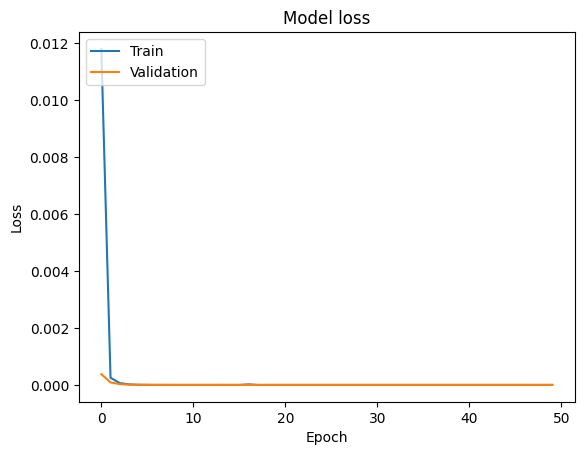

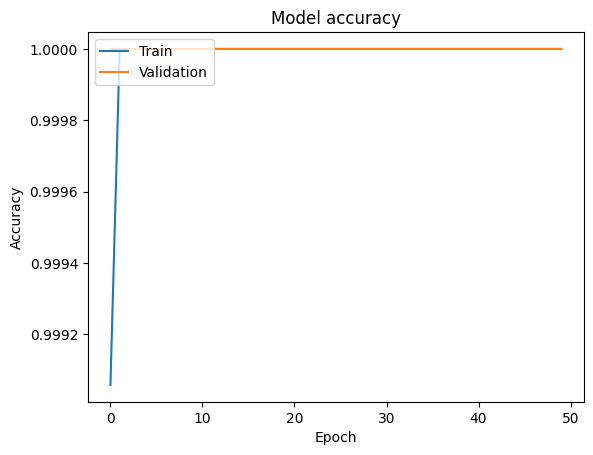

[[186160]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186160

    accuracy                           1.00    186160
   macro avg       1.00      1.00      1.00    186160
weighted avg       1.00      1.00      1.00    186160



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


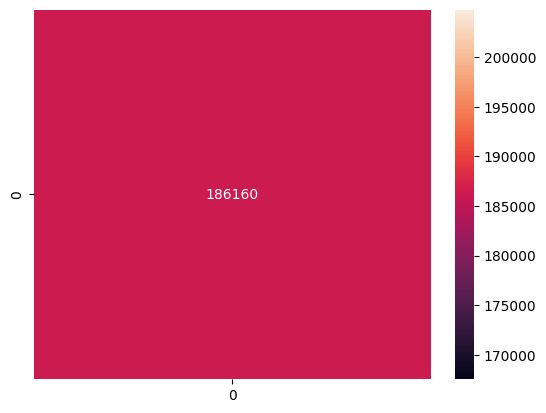

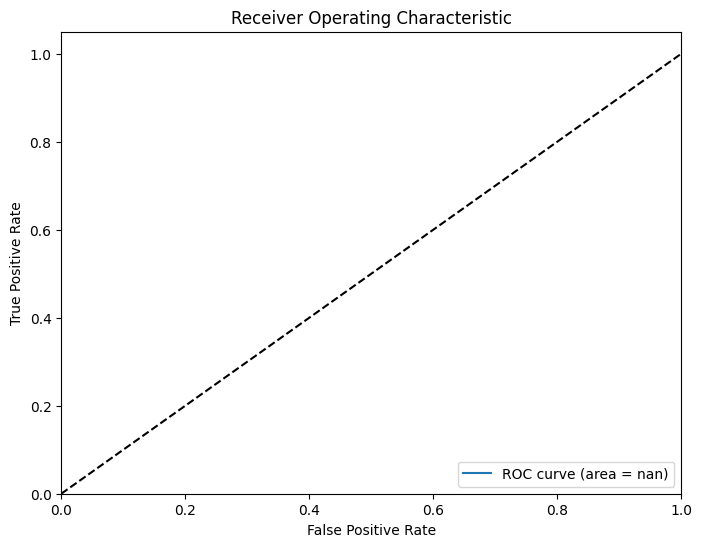

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


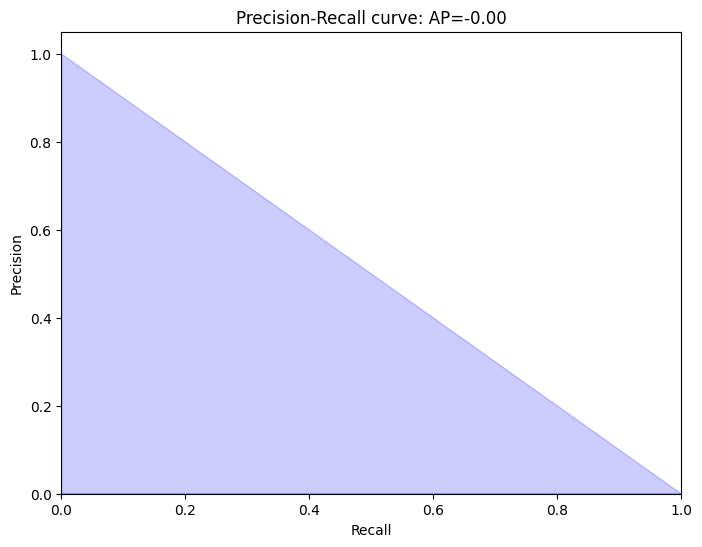

In [165]:
if run_dnn_model_1:
  # Number of neurals. No harm in changing the numbers, no guidelines here.
  L1 = 64 # First hidden layer neurons
  L2 = 32 # Second hidden layer neurons


  # Activation functions
  activation_function = 'relu'
  activation_function2 = 'relu'
  output_activation_function = 'sigmoid' # Multi-class = softmax, Binary = sigmoid, continuous = linear

  # Number of outputs
  # You need to know your columns, for example, you only made a column "Price", so here only one value.
  no_of_output = 1

  # Initialize object
  model = Sequential()

  # First hidden layer
  model.add(Dense(L1, input_dim=X_train.shape[1], activation=activation_function))

  # Dropout Layer
  model.add(Dropout(0.3))

  # Hidden layer
  model.add(Dense(L2, activation=activation_function2))

  # Dropout Layer
  model.add(Dropout(0.3))

  # Output layer
  model.add(Dense(no_of_output,activation=output_activation_function,kernel_regularizer=regularizers.l2(0.01)))

  # Compile the model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Train the model
  history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=128, verbose=1)

  # Make predictions
  y_pred = np.argmax(model.predict(X_test), axis=-1)

  show_model_performance(X_test, y_test, model)
  show_loss_and_accuracy_line_plot(history)
  show_confusion_matrix(y_test, model)
  show_roc_curve_plot(y_test, y_pred)
  show_precision_recall_curve_plot(y_test, y_pred)

## DNN Model 2

Added another Hidden Layer and Dropout Layer. Increased the number of neurons.

In [166]:
if run_dnn_model_2:
  # Number of neurals. No harm in changing the numbers, no guidelines here.
  L1 = 128 # First hidden layer neurons
  L2 = 64 # Second hidden layer neurons
  L3 = 32 # Third hidden layer neurons

  # Activation functions
  activation_function = 'relu'
  activation_function2 = 'relu'
  activation_function3 = 'relu'
  output_activation_function = 'sigmoid' # Multi-class = softmax, Binary = sigmoid, continuous = linear

  # Number of outputs
  # You need to know your columns, for example, you only made a column "Price", so here only one value.
  no_of_output = 1

  # Initialize object
  model = Sequential()

  # First hidden layer
  model.add(Dense(L1, input_dim=X_train.shape[1], activation=activation_function))

  # Dropout Layer
  model.add(Dropout(0.3))

  # Hidden layer
  model.add(Dense(L2, activation=activation_function2))

  # Dropout Layer
  model.add(Dropout(0.3))

  # Hidden layer
  model.add(Dense(L3, activation=activation_function3))

  # Dropout Layer
  model.add(Dropout(0.3))

  # Output layer
  model.add(Dense(no_of_output,activation=output_activation_function,kernel_regularizer=regularizers.l2(0.01)))

  # Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Define early stopping callback
  early_stopping = EarlyStopping(monitor='val_loss', patience=3)

  # Train the model
  history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=128, verbose=1)

  # Make predictions
  y_pred = np.argmax(model.predict(X_test), axis=-1)

  show_model_performance(X_test, y_test, model)
  show_loss_and_accuracy_line_plot(history)
  show_confusion_matrix(y_test, model)
  show_roc_curve_plot(y_test, y_pred)
  show_precision_recall_curve_plot(y_test, y_pred)

# Recurrent Neural Networks (RNN) (Experimental)

In [167]:
# Reload the dataset
df = load_dataset()

# Drop exception columns
df = drop_execption_columns(df)

# Categorize columns
categorize_columns()

# Remove outliers
df = remove_outliers_all_columns(df)

df = remove_multicollinearity_columns(df)

# Define input and output
X = df.drop([target_variable], axis=1)
y = df[target_variable]

print(X)
print(y)
print(X.shape)
print(y.shape)

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Print the datasets' dimension shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_test.shape, y_test.shape)

# Scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Number of records in DG_out.csv: 1000000
Missing values: 
indegree                0
outdegree               0
in_btc                  0
out_btc                 0
total_btc               0
mean_in_btc             0
mean_out_btc            0
in_malicious            0
out_malicious           0
is_malicious            0
out_and_tx_malicious    0
all_malicious           0
dtype: int64
Duplicated records: 
548240
The z-score of the indegree is: 0        -0.300855
1        -0.110560
2        -0.110560
3        -0.110560
4        -0.110560
            ...   
999995   -0.300855
999996   -0.110560
999997    0.460326
999998   -0.110560
999999   -0.110560
Name: indegree, Length: 1000000, dtype: float64
Number of outliers in indegree: 5916
     indegree  outdegree    in_btc  out_btc  total_btc  mean_in_btc  \
29         20          1   1000.00   1000.0    2000.00    50.000000   
98         30          1   1500.00   1500.0    3000.00    50.000000   
108        20          1   1000.00   1000.0    200

## RNN Model 1

In [168]:
if run_rnn_model_1:
  # Define the model
  model = Sequential()
  model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(units=1, activation='sigmoid'))

  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Train the model
  history = model.fit(X_train, y_train, epochs=16, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

  # Make predictions
  y_pred = np.argmax(model.predict(X_test), axis=-1)

  show_model_performance(X_test, y_test, model)
  show_loss_and_accuracy_line_plot(history)
  show_confusion_matrix(y_test, model)
  show_roc_curve_plot(y_test, y_pred)
  show_precision_recall_curve_plot(y_test, y_pred)

Analysis: The model is overfitting. Early Stop mechanism has triggered which stopped the next epoch.

## RNN Model 2

Add regularizers and EarlyStoppings

In [169]:
if run_rnn_model_2:
  model = Sequential()

  # Add LSTM layer
  model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu',
                kernel_regularizer=regularizers.l2(0.001), return_sequences=True))
  model.add(Dropout(0.3))
  model.add(LSTM(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dropout(0.3))

  # Add output layer
  model.add(Dense(1, activation='sigmoid'))

  # Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Define early stopping callback
  early_stopping = EarlyStopping(monitor='val_loss', patience=3)

  # Train model
  history = model.fit(X_train, y_train, epochs=16, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

  # Make predictions
  y_pred = np.argmax(model.predict(X_test), axis=-1)

  show_model_performance(X_test, y_test, model)
  show_loss_and_accuracy_line_plot(history)
  show_confusion_matrix(y_test, model)
  show_roc_curve_plot(y_test, y_pred)
  show_precision_recall_curve_plot(y_test, y_pred)